In [1]:
from langchain_qdrant import QdrantVectorStore, FastEmbedSparse
from qdrant_client import QdrantClient
from dotenv import load_dotenv
import os
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_community.tools import WikipediaQueryRun
from langchain_tavily import TavilySearch
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.tools import Tool
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain.agents import create_agent


from dataclasses import dataclass
from pydantic import BaseModel, Field
from typing import List
from langchain_core.documents import Document

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from typing import List, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage
from pprint import pprint
load_dotenv()


c:\RAG\MultiAgent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class ProcessLoader:

    def __init__(self):
        self.client = QdrantClient(
                            url=os.getenv('QDRANT_API_URL'),
                            api_key=os.getenv('QDRANT_API_KEY')
                        )
        self.dense_embedding = HuggingFaceEmbeddings(model = 'sentence-transformers/all-MiniLM-L12-v2')
        self.sparse_embedding = FastEmbedSparse(model_name ='Qdrant/bm25')
        
        self.qdrantdb = QdrantVectorStore(
            client=self.client,
            collection_name= os.getenv('COLLECTIONNAME'),
            embedding=self.dense_embedding,
            sparse_embedding=self.sparse_embedding
        )
        self.wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results= 5, doc_content_chars_max= 2000))
        self.tavily_tool = TavilySearch(
            max_results=5,
            topic="general",
        )

    @property
    def getPBIRetriver(self):

        return self.qdrantdb.as_retriever(
            search_type = 'mmr',
                search_kwarg = {
                    "k":10
                }
        )
    
    @property
    def wikiTool(self):
        return self.wiki_tool
    
    @property
    def tavilyTool(self):
        return self.tavily_tool
    
    @property
    def getllm(self):
        return ChatGroq(model='openai/gpt-oss-120b')
    
    


In [3]:
obj = ProcessLoader()
pbiRetriver = obj.getPBIRetriver

In [4]:
def generateRetriverDocs() -> Tool:

    """ 
    Retrieves relevant documents from a vector store based on a query sent by LLM. 
    This node handles the critical step of fetching context based on question attribute of state.


    :returs : Object of SelfReflection type where retrivedDocs will be populated by retriver (pbiRetriver)  
    """
    print('---- In generateRetriverDocs-------')
    def toolFun(query: str) -> str:
        results = pbiRetriver.invoke(query)
        return '\n\n'.join([doc.page_content for doc in results])
    
    return Tool(
        llm = obj.getllm,
        name= "getPowerBIDocs",
        description= "Power BI Docs",
        func= toolFun

    )
    





In [5]:
tavilyTool = obj.tavilyTool
wikiTool = obj.wikiTool
pbiTool = generateRetriverDocs()

---- In generateRetriverDocs-------


In [6]:
tools_pbiTool = [pbiTool]
tool_webenhancer = [tavilyTool, wikiTool]

In [7]:
def getExtractorPrompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [8]:
def getEnhancerPrompt(promptInstruction : str) -> str:

    return f""" 
                ### 📝 GENERIC RESEARCH MANDATE ###

                    **PRIMARY TOPIC:** Based on User Query Topic should be taken

                    **RESEARCH OBJECTIVE:**
                    You are an expert, objective research analyst. Your task is to produce a comprehensive, multi-faceted report on the **PRIMARY TOPIC** that achieves a deep understanding of its current state, challenges, and future trajectory.

                    ---

                    ### 🔍 RESEARCH SCOPE & CONSTRAINTS ###
                    * **Timeframe:** Focus primarily on developments and data from the last **5 years** (e.g., 2020–present), unless historical context is strictly necessary to understand the current state.
                    * **Depth:** Research must move beyond Wikipedia-level summaries and include synthesis, analysis, and critical evaluation of information.
                    * **Exclusions:** Avoid pure dictionary definitions or tangential subjects. Focus exclusively on the topic's direct implications.

                    ---

                    ### 🔑 MANDATORY REPORT SECTIONS ###

                    The final output MUST be organized into the following four distinct sections.

                    **SECTION 1: Overview & Current State**
                    * **Goal:** Define the topic and establish its importance.
                    * **Content:** Provide a concise, professional definition. Detail the topic's current scale, major players, or widely accepted status quo.

                    **SECTION 2: Key Challenges & Controversies**
                    * **Goal:** Identify and analyze critical obstacles.
                    * **Content:** Identify and analyze the **three most significant challenges** or **major points of controversy** surrounding the topic. For each challenge, explain the nature of the problem and its primary contributing factors.

                    **SECTION 3: Emerging Trends & Future Trajectory**
                    * **Goal:** Forecast and highlight new developments.
                    * **Content:** Identify and analyze **two major emerging trends** or **potential future applications/solutions** that are likely to shape the topic over the next 5–10 years.

                    **SECTION 4: Conclusion & Strategic Implications**
                    * **Goal:** Summarize findings and provide actionable takeaways.
                    * **Content:** Summarize the main analytical findings. Answer this critical question: **"What is the single most important strategic implication for an organization or individual engaging with this topic?"**

                    ---

                    ### ✨ OUTPUT FORMATTING RULES ###
                    1.  **Tone:** Maintain an **analytical, objective, and professional** tone throughout.
                    2.  **Citations (Fictional):** For each of the three mandatory challenges and two emerging trends, invent and list a realistic-sounding **source type** (e.g., "[Source: 2024 Market Analysis Report]", "[Source: Nature Communications Paper, 2023]"). This simulates a research process and improves analytical depth.
                    3.  **Formatting:** Use markdown headings and bolding to clearly delineate the four sections and their sub-points.

                    NOTE: {promptInstruction}
                """

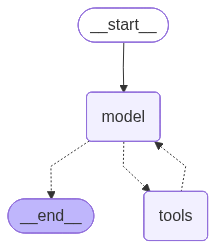

In [9]:
research_agent=create_agent(
                obj.getllm,
                tools=tools_pbiTool,
                system_prompt=getExtractorPrompt("You are agent extracts as much as information. Use the tool that you are binded with, you can use both of them" \
                " You are working with a content writer colleague.")
)

research_agent


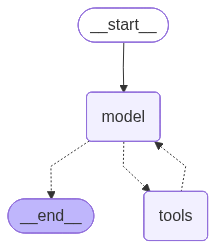

In [10]:
enhancer_agent=create_agent(
                obj.getllm,
                tools=tool_webenhancer,
                system_prompt=getEnhancerPrompt("You are agent extracts as much as information. Use the tool that you are binded with, you can use both of them" \
                " You are working with a content writer colleague.")
)

enhancer_agent

In [11]:
@dataclass
class MyastreamBot:
    messages: Annotated[List[AnyMessage], add_messages]

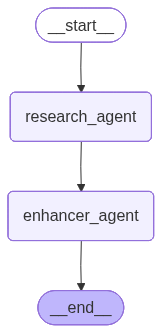

In [12]:
graph = StateGraph(MyastreamBot)

graph.add_node("research_agent", research_agent)
graph.add_node("enhancer_agent", enhancer_agent)

graph.add_edge(START, "research_agent")
graph.add_edge("research_agent", "enhancer_agent")

graph.add_edge("enhancer_agent", END)

graph_builder = graph.compile()
graph_builder

In [13]:
result = graph_builder.invoke(MyastreamBot(messages=HumanMessage("I want to Write a Research Papar on Power BI, Can you please help")))
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

I want to Write a Research Papar on Power BI, Can you please help
================================== Ai Message ==================================
Tool Calls:
  getPowerBIDocs (fc_4d24146f-698d-4323-8a6f-ee9a50a001e6)
 Call ID: fc_4d24146f-698d-4323-8a6f-ee9a50a001e6
  Args:
    __arg1: Power BI overview
================================= Tool Message =================================
Name: getPowerBIDocs

What is Power BI? Power BI is a collection of software services, apps, and connectors that work together to turn your unrelated sources of data into coherent, visually immersive, and interactive insights.1 ●​ Purpose: Its main purpose is to enable users to create reports and dashboards that provide business analytics and insights, allowing them to make data-driven decisions.2​ ●​ Capabilities: It offers capabilities like data connectivity to hundreds of sources, powerful data modeling (creating relations